# Evaluation scores



example: <br>
higher log probability ==> predicted class
if [score 0]=-2 and [score 1]=-3 then it means that the predicted class is class 0 <br>
[score] = -2+3 = 1 > 0 --> class 0
<br>
###########
<br>
if [score 0]=-3 and [score 1]=-2 then it means that the predicted class is class 1 <br>
[score] = -3+2 = -1 < 0 --> class 1

***
## Load the scores

In [1]:
import csv
import pandas as pd
from src.utils import *
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_curve, auc

In [3]:
# paths to csv score files
probs_clean_csv = '../eval/prob_resnet_spec_eval.csv'
#score_2dot0_csv = '../eval/scores_resnet_spec_eval_FGSM_2dot0.csv' 
#score_3dot0_csv = '../eval/scores_resnet_spec_eval_FGSM_3dot0.csv'

probs_clean = pd.read_csv(probs_clean_csv, delimiter=' ', header=None, engine='python')
#scores_2dot0 = pd.read_csv(score_2dot0_csv, delimiter=' ', header=None, engine='python')
#scores_3dot0 = pd.read_csv(score_3dot0_csv, delimiter=' ', header=None, engine='python')

In [4]:
# ground truth file of evaluation dataset (ASVSpoof2019)
config_path = '../config/residualnet_train_config.yaml'
config = read_yaml(config_path)
df_eval = pd.read_csv(os.path.join('..', config['df_eval_path']))

In [ ]:
# print(f'The length of the evaluation file list is {len(df_eval)}\n'
#     f'The length of the clean score list is {len(scores_clean)}\n'
#     f'The length of the epsilon=2.0 score list is {len(scores_2dot0)}\n'
#     f'The length of the epsilon=3.0 score list is {len(scores_3dot0)}')

***
## Accuracies

In [12]:
# the score values .csv uses a space as a delimiter between the file path and the score

def convert_column_to_binary(csv_file):
    binary_list = []
    
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        next(reader) # skip the header
        for line in reader:
            val_1 = float(line[1])
            val_2 = float(line[2])
            
            try:
                if val_1 > val_2:
                    binary_list.append(0)
                else:
                    binary_list.append(1)
            except ValueError:
                pass
        
    return binary_list

In [13]:
pred_labels_clean = convert_column_to_binary(csv_file=probs_clean_csv)
#pred_labels_2dot0 = convert_column_to_binary(csv_file=score_2dot0_csv)
#pred_labels_3dot0 = convert_column_to_binary(csv_file=score_3dot0_csv)

In [6]:
# get the GT labels
GT_labels = df_eval.iloc[:, -1].tolist()

### Unbalanced accuracy

In [16]:
unb_acc_clean = accuracy_score(y_true=GT_labels, y_pred=pred_labels_clean)
#unb_acc_2dot0 = accuracy_score(y_true=GT_labels, y_pred=pred_labels_2dot0)
#unb_acc_3dot0 = accuracy_score(y_true=GT_labels, y_pred=pred_labels_3dot0)

# print(f'The unbalanced acc for clean eval set is {unb_acc_clean*100:.2f}%\n'
#       f'The unbalanced acc for epsilon = 2.0 set is {unb_acc_2dot0*100:.2f}%\n'
#       f'The unbalanced acc for epsilon = 3.0 set is {unb_acc_3dot0*100:.2f}%')


In [17]:
unb_acc_clean

0.7715232252902284

### Balanced accuracy

In [18]:
bal_acc_clean = balanced_accuracy_score(y_true=GT_labels, y_pred=pred_labels_clean)
#bal_acc_2dot0 = balanced_accuracy_score(y_true=GT_labels, y_pred=pred_labels_2dot0)
#bal_acc_3dot0 = balanced_accuracy_score(y_true=GT_labels, y_pred=pred_labels_3dot0)

# print(f'The balanced acc for clean eval set is {bal_acc_clean*100:.2f}%\n'
#       f'The balanced acc for epsilon = 2.0 set is {bal_acc_2dot0*100:.2f}%\n'
#       f'The balanced acc for epsilon = 3.0 set is {bal_acc_3dot0*100:.2f}%')

In [19]:
bal_acc_clean

0.8421107771549647

***
## ROC curve and AUC

In [27]:
def create_prob_pos_class_list(csv_file):
    probs_pos_class = []
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        next(reader) # skip the header
        for row in reader:
            val = float(row[2])
            probs_pos_class.append(val)
    return probs_pos_class

In [28]:
positive_class_probs = create_prob_pos_class_list(probs_clean_csv)

In [29]:
positive_class_probs

[0.48780534,
 1.0,
 1.0,
 0.9817407,
 0.96985245,
 0.07430472,
 0.9997313,
 0.029095853,
 0.6075092,
 0.03741779,
 0.31055078,
 1.0,
 0.37272164,
 1.0,
 0.12848933,
 0.00052772835,
 1.0,
 0.00028928535,
 0.99998045,
 0.60022813,
 0.09772603,
 0.99962693,
 0.29501596,
 0.99999976,
 0.23267157,
 0.1571131,
 0.06307104,
 0.6207094,
 1.0,
 0.01925409,
 0.1486297,
 0.9990645,
 0.5588632,
 0.30918857,
 0.9999982,
 1.0,
 0.9999937,
 0.9999999,
 0.020048494,
 0.003612324,
 0.99979,
 0.05620907,
 0.9816051,
 0.41404644,
 0.9999999,
 0.007935146,
 0.64915484,
 0.60640705,
 0.0072276103,
 0.99930555,
 0.5688105,
 0.31794983,
 0.010342249,
 1.0,
 1.0,
 0.99374634,
 0.4234997,
 1.0,
 1.0,
 0.9985207,
 1.0,
 0.5984714,
 0.7706817,
 0.29410684,
 0.40603596,
 0.99999964,
 0.9999976,
 1.0,
 0.58013266,
 0.98969275,
 0.039306313,
 0.9999993,
 0.7350455,
 0.9878923,
 0.0005229655,
 0.2860555,
 0.9965755,
 1.0,
 0.33980805,
 0.763775,
 1.0,
 1.0,
 0.2829819,
 0.9998956,
 1.0,
 0.9656887,
 0.011791069,
 0.

In [30]:
FP_clean, TP_clean, _ = roc_curve(GT_labels, positive_class_probs)
ROC_AUC_clean = auc(FP_clean, TP_clean)

# FP_2dot0, TP_2dot0, _ = roc_curve(GT_labels, pred_labels_2dot0)
# ROC_AUC_2dot0 = auc(FP_2dot0, TP_2dot0)
# 
# FP_3dot0, TP_3dot0, _ = roc_curve(GT_labels, pred_labels_3dot0)
# ROC_AUC_3dot0 = auc(FP_3dot0, TP_3dot0)

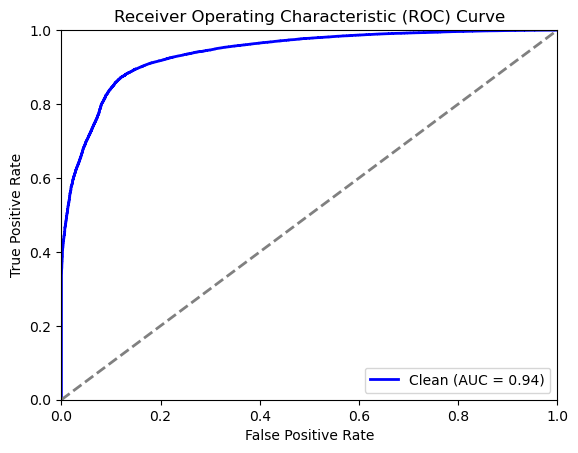

In [31]:
plt.figure()
plt.plot(FP_clean, TP_clean, color='blue', lw=2, label=f'Clean (AUC = {ROC_AUC_clean:.2f})')
# plt.plot(FP_2dot0, TP_2dot0, color='green', lw=2, label=f'FGSM eps=2.0 (AUC = {ROC_AUC_2dot0:.2f})')
# plt.plot(FP_3dot0, TP_3dot0, color='red', lw=2, label=f'FGSM eps=3.0 (AUC = {ROC_AUC_3dot0:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Computing the confusion matrix
* TN true negative, actual class was 0 (BF) and predicted as 0
* FP false positive, actual class was 0, but predicted as 1 (deep fake)
* FN false negative, actual class was 1, but predicted as 0
* TP true positive, actual class was 1 and predicted as 1

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(GT_labels, pred_labels_2dot0)
print(cm)

# [ TN    FP
#   FN    TP ]

## Computing the indices of true positives
aka those audios with GT=1 and prediction=1, which means they are DF and the model correctly identified them as DF


In [ ]:
# def find_TP(list1, list2):
#     if len(list1) != len(list2):
#         raise ValueError
#     list = []
#     for i in range(len(list1)):
#         if (list1[i]==1 & list2[i]==1):
#             list.append(i)
#     return list    
# 
# TP_indices = find_TP(true_labels, pred_labels)
# TP_indices[:10]